In [1]:
import numpy as np
import onnxruntime as rt

session = rt.InferenceSession('Data/MaskRCNN-10.onnx')
input_name = session.get_inputs()[0].name
print(input_name)

image


In [2]:
import math
import numpy as np
from PIL import Image

def preprocess(image):
    # Resize
    ratio = 800.0 / min(image.size[0], image.size[1])
    image = image.resize((int(ratio * image.size[0]), int(ratio * image.size[1])), Image.BILINEAR)
    
    #print(image.size)

    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Normalize
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    for i in range(image.shape[0]):
        image[i, :, :] = image[i, :, :] - mean_vec[i]

    # Pad to be divisible by 32
    padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    padded_w = int(math.ceil(image.shape[2] / 32) * 32)

    padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    padded_image[:, :image.shape[1], :image.shape[2]] = image
    image = padded_image

    return image

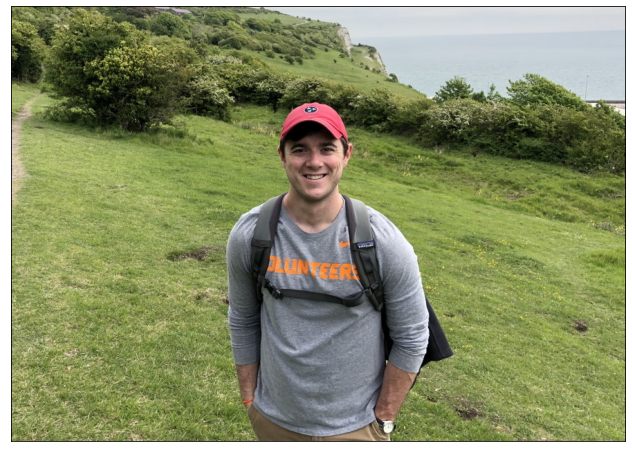

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

img = Image.open('Data/adam.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(img)

In [4]:
img_data = preprocess(img)
result = session.run(None, { input_name: img_data })
print(result)

[array([[ 374.9949 ,  172.2265 ,  799.15967,  792.1767 ],
       [ 428.6951 ,  341.73282,  699.55225,  599.032  ],
       [ 756.88654,  530.59015,  814.6928 ,  660.36053],
       [ 433.3851 ,  352.42178,  674.7178 ,  482.5983 ],
       [ 608.62885,  350.068  ,  683.72455,  547.48096],
       [ 438.22144,  352.05103,  497.57153,  516.7843 ],
       [ 628.2394 ,  354.78027,  799.3827 ,  721.29504],
       [ 433.2032 ,  334.6126 ,  709.9705 ,  753.3559 ],
       [1151.8395 ,    0.     , 1164.1874 ,   16.95084],
       [ 438.237  ,  347.46698,  587.6325 ,  546.2621 ],
       [ 718.3266 ,  493.09512,  816.1408 ,  666.26587],
       [ 417.32715,  394.5539 ,  694.5675 ,  511.6256 ],
       [ 684.25543,  765.6719 ,  700.8055 ,  783.3452 ]], dtype=float32), array([ 1, 25, 27, 25, 25, 25, 27, 27,  1, 25, 27, 25, 75], dtype=int64), array([0.99910897, 0.7602388 , 0.4377254 , 0.17998308, 0.16174279,
       0.1343054 , 0.09488755, 0.08665401, 0.07417456, 0.06496262,
       0.06451564, 0.0641586 , 0.

In [5]:
result[0]

array([[ 374.9949 ,  172.2265 ,  799.15967,  792.1767 ],
       [ 428.6951 ,  341.73282,  699.55225,  599.032  ],
       [ 756.88654,  530.59015,  814.6928 ,  660.36053],
       [ 433.3851 ,  352.42178,  674.7178 ,  482.5983 ],
       [ 608.62885,  350.068  ,  683.72455,  547.48096],
       [ 438.22144,  352.05103,  497.57153,  516.7843 ],
       [ 628.2394 ,  354.78027,  799.3827 ,  721.29504],
       [ 433.2032 ,  334.6126 ,  709.9705 ,  753.3559 ],
       [1151.8395 ,    0.     , 1164.1874 ,   16.95084],
       [ 438.237  ,  347.46698,  587.6325 ,  546.2621 ],
       [ 718.3266 ,  493.09512,  816.1408 ,  666.26587],
       [ 417.32715,  394.5539 ,  694.5675 ,  511.6256 ],
       [ 684.25543,  765.6719 ,  700.8055 ,  783.3452 ]], dtype=float32)

In [6]:
boxes = result[0]   # NodeArg(name='6568', type='tensor(float)', shape=['nbox', 4])
labels = result[1]  # NodeArg(name='6570', type='tensor(int64)', shape=['nbox'])
scores = result[2]  # NodeArg(name='6572', type='tensor(float)', shape=['nbox'])
masks = result[3]   # NodeArg(name='6887', type='tensor(float)', shape=['nbox', 1, 28, 28])

In [7]:
import cv2
from matplotlib.patches import Rectangle

def display_objects(image, boxes, labels, scores, masks, score_threshold=0.7,
                    mask_color=(255, 0, 255), mask_opacity=0.4, show_boxes=True, show_masks=True):
    # Resize boxes
    ratio = 800.0 / min(image.size[0], image.size[1])
    boxes /= ratio

    _, ax = plt.subplots(1, figsize=(12,9), subplot_kw={'xticks': [], 'yticks': []})

    image = np.array(image)

    for mask, box, label, score in zip(masks, boxes, labels, scores):
        if score <= score_threshold:
            continue

        if (show_masks):
            mask = mask[0, :, :, None]
            int_box = [int(i) for i in box]
            mask = cv2.resize(mask, (int_box[2]-int_box[0]+1, int_box[3]-int_box[1]+1))
            mask = mask > 0.5
            im_mask = np.zeros(image.shape[:-1], dtype=np.uint8)
            x_0 = max(int_box[0], 0)
            x_1 = min(int_box[2] + 1, image.shape[1])
            y_0 = max(int_box[1], 0)
            y_1 = min(int_box[3] + 1, image.shape[0])
            mask_y_0 = max(y_0 - box[1], 0)
            mask_y_1 = mask_y_0 + y_1 - y_0
            mask_x_0 = max(x_0 - box[0], 0)
            mask_x_1 = mask_x_0 + x_1 - x_0
            im_mask[y_0:y_1, x_0:x_1] = mask[mask_y_0 : mask_y_1, mask_x_0 : mask_x_1]
            im_mask = im_mask[:, :, None]

            contours, hierarchy = cv2.findContours(im_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

            im_copy= image.copy()
            
            for i, cont in enumerate(contours):
                im_copy = cv2.drawContours(im_copy, [cont], -1, mask_color, thickness=cv2.FILLED)
                image = cv2.addWeighted(im_copy, mask_opacity, image, 1.0 - mask_opacity, 0.0)

        if (show_boxes):
            x, y, w, h = box[0], box[1], box[2] - box[0], box[3] - box[1]
            rect = Rectangle((x, y), w, h, edgecolor='r', lw=2, facecolor='none')
            text = f'{classes[label]} ({score:.1%})'
            ax.text(x + (w / 2), y, text, color='white', backgroundcolor='red',
                    ha='center', va='bottom', fontweight='bold', bbox=dict(color='red'))    
            ax.add_patch(rect)
        
    ax.imshow(image)

In [8]:
# Classes for the COCO dataset
classes = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', \
          'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', \
          'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', \
          'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', \
          'ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', \
          'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', \
          'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', \
          'chair', 'sofa', 'potted plant', 'bed', 'dining table', 'toilet', 'tv monitor', 'laptop', 'mouse', \
          'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', \
          'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [15]:
classes[25]

'backpack'

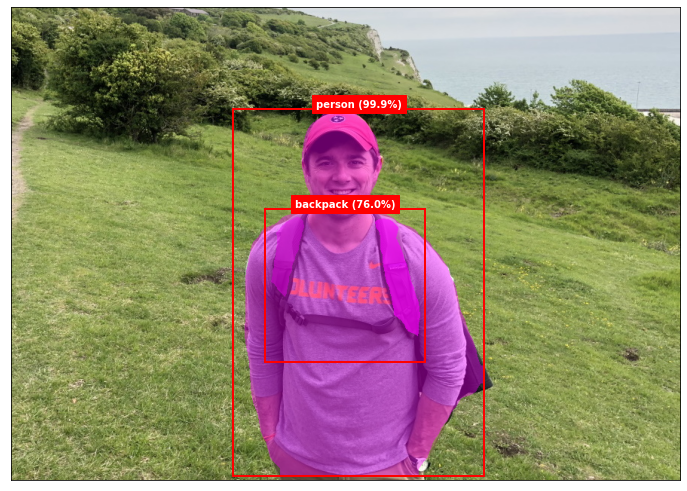

In [10]:
display_objects(img, boxes, labels, scores, masks)

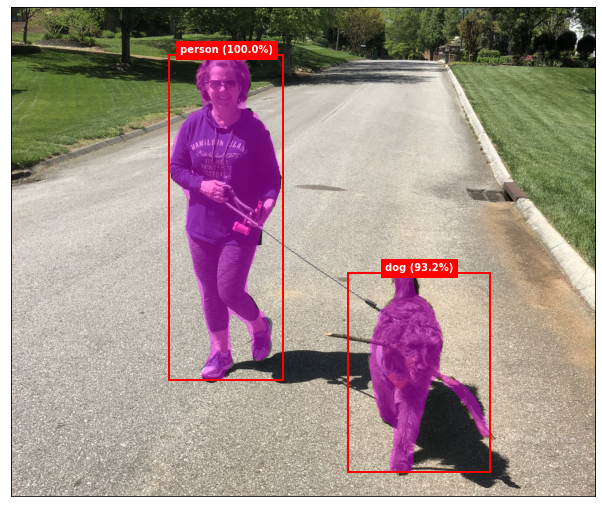

In [11]:
img = Image.open('Data/lady.jpg')
img_data = preprocess(img)
result = session.run(None, { input_name: img_data })

boxes = result[0]   # NodeArg(name='6568', type='tensor(float)', shape=['nbox', 4])
labels = result[1]  # NodeArg(name='6570', type='tensor(int64)', shape=['nbox'])
scores = result[2]  # NodeArg(name='6572', type='tensor(float)', shape=['nbox'])
masks = result[3]   # NodeArg(name='6887', type='tensor(float)', shape=['nbox', 1, 28, 28])

display_objects(img, boxes, labels, scores, masks)

In [12]:
# https://stackoverflow.com/questions/36921496/how-to-join-png-with-alpha-transparency-in-a-frame-in-realtime

def blend_transparent(face_img, overlay_t_img):
    # Split out the transparency mask from the colour info
    overlay_img = overlay_t_img[:,:,:3] # Grab the BRG planes
    overlay_mask = overlay_t_img[:,:,3:]  # And the alpha plane

    # Again calculate the inverse mask
    background_mask = 255 - overlay_mask

    # Turn the masks into three channel, so we can use them as weights
    overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
    background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

    # Create a masked out face image, and masked out overlay
    # We convert the images to floating point in range 0.0 - 1.0
    face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
    overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

    # And finally just add them together, and rescale it back to an 8bit integer image    
    return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))

In [13]:
def change_background(session, foregroundImage, backgroundImage, score_threshold=0.7):
    #Submit foreground image to Mask R-CNN
    img_data = preprocess(foregroundImage)
    result = session.run(None, { input_name: img_data })

    # Extract the results
    boxes = result[0]
    labels = result[1]
    scores = result[2]
    masks = result[3]

    # Scale boxes to match original image size
    ratio = 800.0 / min(foregroundImage.size[0], foregroundImage.size[1])
    boxes /= ratio
    
    _, ax = plt.subplots(1, figsize=(12,9), subplot_kw={'xticks': [], 'yticks': []})

    foregroundImage = np.array(foregroundImage)
    backgroundImage = np.array(backgroundImage)
    
    foregroundImage = cv2.cvtColor(foregroundImage, cv2.COLOR_BGR2BGRA)
    #backgroundImage = cv2.cvtColor(backgroundImage, cv2.COLOR_BGR2BGRA)
    backgroundImage = cv2.resize(backgroundImage, foregroundImage.shape[1::-1])
    
    for mask, box, label, score in zip(masks, boxes, labels, scores):
        if score <= score_threshold:
            continue

        mask = mask[0, :, :, None]
        int_box = [int(i) for i in box]
        mask = cv2.resize(mask, (int_box[2]-int_box[0]+1, int_box[3]-int_box[1]+1))
        mask = mask > 0.5
        im_mask = np.zeros(foregroundImage.shape[:-1], dtype=np.uint8)
        x_0 = max(int_box[0], 0)
        x_1 = min(int_box[2] + 1, foregroundImage.shape[1])
        y_0 = max(int_box[1], 0)
        y_1 = min(int_box[3] + 1, foregroundImage.shape[0])
        mask_y_0 = max(y_0 - box[1], 0)
        mask_y_1 = mask_y_0 + y_1 - y_0
        mask_x_0 = max(x_0 - box[0], 0)
        mask_x_1 = mask_x_0 + x_1 - x_0
        im_mask[y_0:y_1, x_0:x_1] = mask[mask_y_0 : mask_y_1, mask_x_0 : mask_x_1]
        im_mask = im_mask[:, :, None]

        contours, hierarchy = cv2.findContours(im_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        mask_val = 1
        stencil  = np.zeros(foregroundImage.shape[:-1]).astype(np.uint8)
        cv2.fillPoly(stencil, contours, mask_val)
        im_copy = foregroundImage.copy()
        im_copy[stencil != mask_val] = (0, 0, 0, 0)

        backgroundImage = blend_transparent(backgroundImage, im_copy)
        
        
        #backgroundImage = cv2.addWeighted(im_copy, 1.0, backgroundImage, 1.0, 0)

    ax.imshow(backgroundImage)

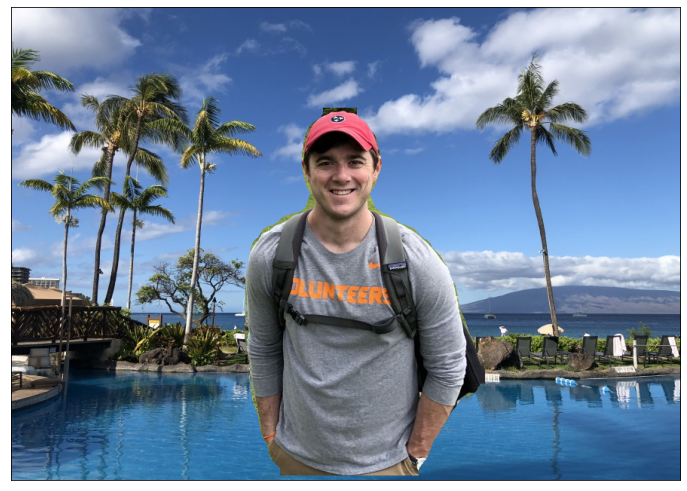

In [14]:
fg = Image.open('Data/adam.jpg')
bg = Image.open('Data/maui.jpg')
change_background(session, fg, bg)